# Loan eligibility project

## Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
#from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

## Importing data

In [2]:
df=pd.read_csv('loan_data.csv')
df.shape

(614, 13)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


## Dealing with cases of missing data

In [5]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### For object variables we use their mode 

In [6]:
print(df['Gender'].mode())
print(df['Married'].mode())
print(df['Self_Employed'].mode())

0    Male
dtype: object
0    Yes
dtype: object
0    No
dtype: object


In [7]:
df['Gender'].fillna('Male', inplace=True)
df['Married'].fillna('Yes', inplace=True)
df['Self_Employed'].fillna('No', inplace=True)

In [8]:
df.apply(lambda x: sum(x.isnull()), axis=0)

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### Now let us fill the missing values of LoanAmount
For each index is made up with a combination of more than one value. In this case we shall index loan amount to "Gender", "Married" and "employment".

In [9]:
impute_grps = df.pivot_table(values="LoanAmount",index=["Gender","Married","Self_Employed"],aggfunc=np.mean)

#iterate only through rows with missing LoanAmount
for i,row in df.loc[df['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  df.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]

In [10]:
df.apply(lambda x: sum(x.isnull()), axis=0)

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Credit history

In [11]:
df['Credit_History'].fillna(1.0, inplace=True)

In [12]:
#looking at proportion of the credit history
df['Credit_History'].value_counts()

1.0    525
0.0     89
Name: Credit_History, dtype: int64

In [12]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,129.936937,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [13]:
#Probability of getting loan based on the credit history
pd.pivot_table(df,index='Credit_History',values='Loan_Status',aggfunc=lambda x: x.map({'Y':1, 'N':0}).mean())
#this shows that almost 80% of the applicants with good credit history has got the loan

,Loan_Status
Credit_History,
0.0,0.078652
1.0,0.790476


## NOTE
Credit history highly impacts the pprobabilty of getting a loan

In [14]:

#probability of getting loan based on gender
pd.pivot_table(df,index='Gender',values='Loan_Status',aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())



,Loan_Status
Gender,
Female,0.669643
Male,0.691235


Almost men and women has a fair chance of loan acceptance, so Gender doesn't play an important role

In [15]:
#probability of getting loan based on Marital stauts
pd.pivot_table(df,index=['Gender','Married'],values='Loan_Status',aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())



Loan_Status
Gender Married             
Female No          0.637500
       Yes         0.750000
Male   No          0.624060
       Yes         0.715447

Marital status also doesn't seem to have much effect on loan status, but there is a bit more chance of acceptance for married than unmarried

In [16]:
df['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [17]:
df['Dependents'].fillna(0, inplace=True)

In [18]:
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [19]:
df['Loan_Amount_Term'].fillna(360, inplace=True)

In [20]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## DATA EXPLORATION

In [21]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,129.936937,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


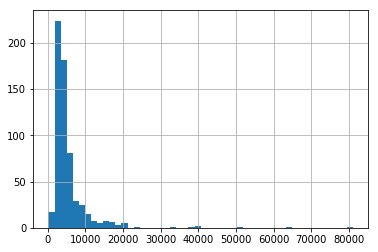

In [22]:
df['ApplicantIncome'].hist(bins=50)

## BUILDING MODEL

Ensuring all the variables are in numeric fomart.

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
var_mod = ['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status']

for i in var_mod:
    df[i] = LabelEncoder().fit_transform(df[i])
    
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents            object
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object

In [25]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,129.936937,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


In [26]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

In [27]:
Feature = df[['Gender','Married','Education','LoanAmount','Credit_History']]
X = Feature
X.shape

(614, 5)

In [28]:
y = df['Loan_Status']
y.shape

(614,)

In [29]:
x_train, x_test, y_train, y_test=train_test_split(X, y, train_size=0.7, random_state=2)

In [30]:
y_train.shape

(429,)

## Normalize data


In [33]:
x_train=preprocessing.StandardScaler().fit(x_train).transform(x_train)
x_test=preprocessing.StandardScaler().fit(x_test).transform(x_test)

x_train[0:5]

array([[ 0.49343516,  0.75592895,  1.86245805,  0.54531623,  0.41873914],
       [ 0.49343516, -1.32287566, -0.53692484, -0.24863433,  0.41873914],
       [ 0.49343516,  0.75592895, -0.53692484,  0.22517488,  0.41873914],
       [ 0.49343516,  0.75592895, -0.53692484,  0.3020088 ,  0.41873914],
       [ 0.49343516,  0.75592895, -0.53692484, -0.26143998,  0.41873914]])

## Logistic regration

In [34]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(x_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
#Let us try with 'Credit History' as input variable
target_var=df[['Loan_Status']]
input_var=df[['Credit_History']]
model=LogisticRegression()
model.fit(input_var, target_var)
model.score(input_var, target_var)

0.8094462540716613

In [36]:
#Now using multiple variables
#LR_model.fit(X, target_var)
LR_model.score(x_test, y_test)

0.8

We can clearly see that 'Credit history' is slightly more dorminant compared to all the other variables. There is no increase in accuracy but rather a small decrease when other variables are added to it.

## K nearest neighbours

In [37]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 3
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(x_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [38]:
# just for sanity chaeck
yhat = kNN_model.predict(x_test)
yhat[0:5]

array([0, 0, 1, 1, 1], dtype=int64)

In [39]:
# Best k
Ks=15
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(x_train,y_train)
    yhat = kNN_model.predict(x_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.74054054, 0.67027027, 0.77837838, 0.74594595, 0.78378378,
       0.76216216, 0.80540541, 0.79459459, 0.80540541, 0.8       ,
       0.8       , 0.79459459, 0.80540541, 0.8       ])

In [40]:
# Building the model again, using k=9
from sklearn.neighbors import KNeighborsClassifier
k = 9
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(x_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [41]:
kNN_model.score(x_test, y_test)

0.8054054054054054

## Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(x_train,y_train)
DT_model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [43]:
DT_model.score(x_test, y_test)

0.7945945945945946

## Support Vector Machine

In [44]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(x_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
yhat = SVM_model.predict(x_test)
yhat

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

In [46]:
SVM_model.score(x_test, y_test)

0.7945945945945946

# Model evaluation
We will use the Jaccard coefficient that measures similarity between finite sample sets

In [47]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [49]:
knn_yhat = kNN_model.predict(x_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )

KNN Jaccard index: 0.81
KNN F1-score: 0.78


In [48]:
DT_yhat = DT_model.predict(x_test)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(y_test, DT_yhat))
print("DT F1-score: %.2f" % f1_score(y_test, DT_yhat, average='weighted') )

DT Jaccard index: 0.79
DT F1-score: 0.77


In [50]:
SVM_yhat = SVM_model.predict(x_test)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(y_test, SVM_yhat))
print("SVM F1-score: %.2f" % f1_score(y_test, SVM_yhat, average='weighted') )

SVM Jaccard index: 0.79
SVM F1-score: 0.77


In [51]:
LR_yhat = LR_model.predict(x_test)
LR_yhat_prob = LR_model.predict_proba(x_test)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_yhat))
print("LR F1-score: %.2f" % f1_score(y_test, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

LR Jaccard index: 0.80
LR F1-score: 0.77
LR LogLoss: 0.55


## Report

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.81    | 0.78     | NA      |
| Decision Tree      | 0.79    | 0.77     | NA      |
| SVM                | 0.79    | 0.77     | NA      |
| LogisticRegression | 0.80    | 0.77     | 0.57    |